In [ ]:
pip install tensorflow==1.13.1

In [ ]:
pip install scipy

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [ ]:
pip install protobuf==3.20.0


In [ ]:
pip install bottleneck

In [1]:
import os
import shutil
import sys

import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn
sn.set()

import pandas as pd

import tensorflow as tf
from tensorflow.contrib.layers import apply_regularization, l2_regularizer

import bottleneck as bn

/home/vkattera/py-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vkattera/py-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vkattera/py-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vkattera/py-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [2]:
raw_data = pd.read_csv('ml-1m/ml-1m/ratings.dat',header=None, delimiter='::', names = ['userId','movieId','rating','timestamp'])

/home/vkattera/py-env/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [3]:
raw_data

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [4]:
raw_movies = pd.read_csv('ml-1m/ml-1m/movies.dat',header=None, delimiter='::', names = ['movieId', 'title', 'genres'],encoding='ISO-8859-1')

/home/vkattera/py-env/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [5]:
raw_movies['genres'] = raw_movies['genres'].apply(lambda x: x.split('|') if pd.notnull(x) else [])
item_to_genre = pd.Series(raw_movies['genres'].values, index=raw_movies['movieId']).to_dict()

# Print the dictionary to check
for key in list(item_to_genre.keys())[:5]:  # printing only first 5 for brevity
    print(f"MovieID {key}: Genres {item_to_genre[key]}")


MovieID 1: Genres ['Animation', "Children's", 'Comedy']
MovieID 2: Genres ['Adventure', "Children's", 'Fantasy']
MovieID 3: Genres ['Comedy', 'Romance']
MovieID 4: Genres ['Comedy', 'Drama']
MovieID 5: Genres ['Comedy']


In [6]:
raw_movies[raw_movies['movieId']==1193]

,movieId,title,genres
1176,1193,One Flew Over the Cuckoo's Nest (1975),[Drama]


In [7]:
raw_data = raw_data[raw_data['rating'] > 3.5]

In [8]:
raw_data.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
3,1,3408,4,978300275
4,1,2355,5,978824291
6,1,1287,5,978302039
7,1,2804,5,978300719


In [9]:
def get_count(tp, id):
    playcount_groupbyid = tp.groupby(id, as_index=False).size()
    return playcount_groupbyid

def filter_triplets(tp, min_uc=5, min_sc=0):
    # Only keep the triplets for items which were clicked on by at least min_sc users. 
    if min_sc > 0:
        itemcount = get_count(tp, 'movieId')
        tp = tp[tp['movieId'].isin(itemcount[itemcount['size'] >= min_sc]['movieId'])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    if min_uc > 0:
        usercount = get_count(tp, 'userId')
        tp = tp[tp['userId'].isin(usercount[usercount['size'] >= min_uc]['userId'])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(tp, 'userId'), get_count(tp, 'movieId') 
    return tp, usercount, itemcount

# Assuming raw_data is already defined and is a DataFrame
raw_data, user_activity, item_popularity = filter_triplets(raw_data)


In [10]:
sparsity = 1. * raw_data.shape[0] / (user_activity.shape[0] * item_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (raw_data.shape[0], user_activity.shape[0], item_popularity.shape[0], sparsity * 100))

After filtering, there are 575272 watching events from 6034 users and 3533 movies (sparsity: 2.699%)


In [11]:
unique_uid = len(user_activity)
unique_uid

6034

In [12]:
unique_uid = user_activity.index

np.random.seed(98765)
idx_perm = np.random.permutation(unique_uid.size)
unique_uid = unique_uid[idx_perm]

In [13]:
# create train/validation/test users
n_users = unique_uid.size
n_heldout_users = 600

tr_users = unique_uid[:(n_users - n_heldout_users * 2)]
vd_users = unique_uid[(n_users - n_heldout_users * 2): (n_users - n_heldout_users)]
te_users = unique_uid[(n_users - n_heldout_users):]

In [14]:
tr_users

Int64Index([1866, 5656,  645, 3940, 1411, 5368, 4883, 1495, 2998, 3556,
            ...
            5221, 5104, 2361,  434, 5310, 5595, 4946, 2182, 4746, 3344],
           dtype='int64', length=4834)

In [15]:
vd_users

Int64Index([4044,  979, 3249,  464, 1823, 1002, 3022,  755, 3634, 5161,
            ...
            4904, 1820, 2692, 3686, 3969, 4809,  416, 1461, 5980, 3639],
           dtype='int64', length=600)

In [16]:
te_users

Int64Index([ 781, 1125, 5457, 4887,  792, 3726,  850,  929, 4840, 3386,
            ...
            4479,  921, 1412, 2057, 4827, 5040, 4013, 1388, 3571, 3861],
           dtype='int64', length=600)

In [17]:
train_plays = raw_data.loc[raw_data['userId'].isin(tr_users)]

In [18]:
train_plays

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
3,1,3408,4,978300275
4,1,2355,5,978824291
6,1,1287,5,978302039
7,1,2804,5,978300719
...,...,...,...,...
998325,6033,110,5,956713865
998327,6033,1012,4,956713483
998329,6033,1036,5,956713898
998332,6033,2016,4,956713483


In [19]:
unique_sid = pd.unique(train_plays['movieId'])

In [20]:
show2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
profile2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [21]:
DATA_DIR = 'ml-1m'
pro_dir = os.path.join(DATA_DIR, 'pro_sg')

if not os.path.exists(pro_dir):
    os.makedirs(pro_dir)

with open(os.path.join(pro_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [22]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)

        if n_items_u >= 5:
            idx = np.zeros(n_items_u, dtype='bool')
            idx[np.random.choice(n_items_u, size=int(test_prop * n_items_u), replace=False).astype('int64')] = True

            tr_list.append(group[np.logical_not(idx)])
            te_list.append(group[idx])
        else:
            tr_list.append(group)

        if i % 100 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [23]:
vad_plays = raw_data.loc[raw_data['userId'].isin(vd_users)]
vad_plays = vad_plays.loc[vad_plays['movieId'].isin(unique_sid)]

In [24]:
vad_plays_tr, vad_plays_te = split_train_test_proportion(vad_plays)

0 users sampled
100 users sampled
200 users sampled
300 users sampled
400 users sampled
500 users sampled


In [25]:
test_plays = raw_data.loc[raw_data['userId'].isin(te_users)]
test_plays = test_plays.loc[test_plays['movieId'].isin(unique_sid)]

In [26]:
test_plays_tr, test_plays_te = split_train_test_proportion(test_plays)

0 users sampled
100 users sampled
200 users sampled
300 users sampled
400 users sampled
500 users sampled


In [27]:
def numerize(tp):
    uid = list(map(lambda x: profile2id[x], tp['userId']))
    sid = list(map(lambda x: show2id[x], tp['movieId']))
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [28]:
train_data = numerize(train_plays)
train_data.to_csv(os.path.join(pro_dir, 'train.csv'), index=False)

In [29]:
vad_data_tr = numerize(vad_plays_tr)
vad_data_tr.to_csv(os.path.join(pro_dir, 'validation_tr.csv'), index=False)

In [30]:
vad_data_te = numerize(vad_plays_te)
vad_data_te.to_csv(os.path.join(pro_dir, 'validation_te.csv'), index=False)

In [31]:
test_data_tr = numerize(test_plays_tr)
test_data_tr.to_csv(os.path.join(pro_dir, 'test_tr.csv'), index=False)

In [32]:
test_data_te = numerize(test_plays_te)
test_data_te.to_csv(os.path.join(pro_dir, 'test_te.csv'), index=False)

In [33]:
class MultiDAE(object):
    def __init__(self, p_dims, q_dims=None, lam=0.01, lr=1e-3, random_seed=None):
        self.p_dims = p_dims
        if q_dims is None:
            self.q_dims = p_dims[::-1]
        else:
            assert q_dims[0] == p_dims[-1], "Input and output dimension must equal each other for autoencoders."
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q-network mismatches."
            self.q_dims = q_dims
        self.dims = self.q_dims + self.p_dims[1:]
        
        self.lam = lam
        self.lr = lr
        self.random_seed = random_seed

        self.construct_placeholders()

    def construct_placeholders(self):        
        self.input_ph = tf.placeholder(
            dtype=tf.float32, shape=[None, self.dims[0]])
        self.keep_prob_ph = tf.placeholder_with_default(1.0, shape=None)

    def build_graph(self):

        self.construct_weights()

        saver, logits = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        # per-user average negative log-likelihood
        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph, axis=1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        reg_var = apply_regularization(reg, self.weights)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        loss = neg_ll + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('loss', loss)
        merged = tf.summary.merge_all()
        return saver, logits, loss, train_op, merged

    def forward_pass(self):
        # construct forward graph        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights) - 1:
                h = tf.nn.tanh(h)
        return tf.train.Saver(), h

    def construct_weights(self):

        self.weights = []
        self.biases = []
        
        # define weights
        for i, (d_in, d_out) in enumerate(zip(self.dims[:-1], self.dims[1:])):
            weight_key = "weight_{}to{}".format(i, i+1)
            bias_key = "bias_{}".format(i+1)
            
            self.weights.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights[-1])
            tf.summary.histogram(bias_key, self.biases[-1])

In [34]:
class MultiVAE(MultiDAE):

    def construct_placeholders(self):
        super(MultiVAE, self).construct_placeholders()

        # placeholders with default values when scoring
        self.is_training_ph = tf.placeholder_with_default(0., shape=None)
        self.anneal_ph = tf.placeholder_with_default(1., shape=None)
        
    def build_graph(self):
        self._construct_weights()

        saver, logits, KL = self.forward_pass()
        log_softmax_var = tf.nn.log_softmax(logits)

        neg_ll = -tf.reduce_mean(tf.reduce_sum(
            log_softmax_var * self.input_ph,
            axis=-1))
        # apply regularization to weights
        reg = l2_regularizer(self.lam)
        
        reg_var = apply_regularization(reg, self.weights_q + self.weights_p)
        # tensorflow l2 regularization multiply 0.5 to the l2 norm
        # multiply 2 so that it is back in the same scale
        neg_ELBO = neg_ll + self.anneal_ph * KL + 2 * reg_var
        
        train_op = tf.train.AdamOptimizer(self.lr).minimize(neg_ELBO)

        # add summary statistics
        tf.summary.scalar('negative_multi_ll', neg_ll)
        tf.summary.scalar('KL', KL)
        tf.summary.scalar('neg_ELBO_train', neg_ELBO)
        merged = tf.summary.merge_all()

        return saver, logits, neg_ELBO, train_op, merged
    
    def q_graph(self):
        mu_q, std_q, KL = None, None, None
        
        h = tf.nn.l2_normalize(self.input_ph, 1)
        h = tf.nn.dropout(h, self.keep_prob_ph)
        
        for i, (w, b) in enumerate(zip(self.weights_q, self.biases_q)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_q) - 1:
                h = tf.nn.tanh(h)
            else:
                mu_q = h[:, :self.q_dims[-1]]
                logvar_q = h[:, self.q_dims[-1]:]

                std_q = tf.exp(0.5 * logvar_q)
                KL = tf.reduce_mean(tf.reduce_sum(
                        0.5 * (-logvar_q + tf.exp(logvar_q) + mu_q**2 - 1), axis=1))
        return mu_q, std_q, KL

    def p_graph(self, z):
        h = z
        
        for i, (w, b) in enumerate(zip(self.weights_p, self.biases_p)):
            h = tf.matmul(h, w) + b
            
            if i != len(self.weights_p) - 1:
                h = tf.nn.tanh(h)
        return h

    def forward_pass(self):
        # q-network
        mu_q, std_q, KL = self.q_graph()
        self.kl_divergence = KL
        epsilon = tf.random_normal(tf.shape(std_q))

        sampled_z = mu_q + self.is_training_ph *\
            epsilon * std_q

        # p-network
        logits = self.p_graph(sampled_z)
        
        return tf.train.Saver(), logits, KL

    def _construct_weights(self):
        self.weights_q, self.biases_q = [], []
        
        for i, (d_in, d_out) in enumerate(zip(self.q_dims[:-1], self.q_dims[1:])):
            if i == len(self.q_dims[:-1]) - 1:
                # we need two sets of parameters for mean and variance,
                # respectively
                d_out *= 2
            weight_key = "weight_q_{}to{}".format(i, i+1)
            bias_key = "bias_q_{}".format(i+1)
            
            self.weights_q.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_q.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_q[-1])
            tf.summary.histogram(bias_key, self.biases_q[-1])
            
        self.weights_p, self.biases_p = [], []

        for i, (d_in, d_out) in enumerate(zip(self.p_dims[:-1], self.p_dims[1:])):
            weight_key = "weight_p_{}to{}".format(i, i+1)
            bias_key = "bias_p_{}".format(i+1)
            self.weights_p.append(tf.get_variable(
                name=weight_key, shape=[d_in, d_out],
                initializer=tf.contrib.layers.xavier_initializer(
                    seed=self.random_seed)))
            
            self.biases_p.append(tf.get_variable(
                name=bias_key, shape=[d_out],
                initializer=tf.truncated_normal_initializer(
                    stddev=0.001, seed=self.random_seed)))
            
            # add summary stats
            tf.summary.histogram(weight_key, self.weights_p[-1])
            tf.summary.histogram(bias_key, self.biases_p[-1])

In [35]:
unique_sid = list()
with open(os.path.join(pro_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [36]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [37]:
train_data = load_train_data(os.path.join(pro_dir, 'train.csv'))

In [38]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [39]:
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(pro_dir, 'validation_tr.csv'),
                                           os.path.join(pro_dir, 'validation_te.csv'))

In [40]:
N = train_data.shape[0]
idxlist = list(range(N))

# training batch size
batch_size = 100
batches_per_epoch = int(np.ceil(float(N) / batch_size))

N_vad = vad_data_tr.shape[0]
idxlist_vad = list(range(N_vad))

# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 30

# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2

In [41]:
def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    '''
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    return DCG / IDCG

In [42]:
def Recall_at_k_batch(X_pred, heldout_batch, k=100):
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return recall

In [43]:
#p_dims = [200, 600, n_items]
p_dims = [70, 200, n_items]

In [44]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Use tf.cast instead.


In [45]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))

In [46]:
n_epochs = 200

In [47]:
log_dir = 'ml-1m/volmount/log/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: ml-1m/volmount/log/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-200-70-200-I


In [48]:
chkpt_dir = 'ml-1m/volmount/chkpt/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ml-1m/volmount/chkpt/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-200-70-200-I


In [49]:
ndcgs_vad = []
kl_scores = []  # List to store KL divergence scores for each epoch

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0
    
    for epoch in range(n_epochs):
        np.random.shuffle(idxlist)
        total_kl_score_epoch = 0  # Total KL score for the epoch

        # Train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap
            
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}
            
            _, kl_score = sess.run([train_op_var, vae.kl_divergence], feed_dict=feed_dict)  # Retrieve KL score
            total_kl_score_epoch += kl_score  # Accumulate KL score

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, global_step=epoch * batches_per_epoch + bnum)
            
            update_count += 1

        avg_kl_score_epoch = total_kl_score_epoch / batches_per_epoch  # Average KL score for the epoch
        kl_scores.append(avg_kl_score_epoch)  # Store the average KL score for the epoch

        # Compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')

            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X})
            # Exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)

        # Update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

        print("Epoch: {}, Avg NDCG: {:.4f}, Avg KL Div: {:.4f}".format(epoch, ndcg_, avg_kl_score_epoch))


2023-12-03 18:43:41.360054: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-12-03 18:43:41.375719: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2794965000 Hz
2023-12-03 18:43:41.376008: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x8165590 executing computations on platform Host. Devices:
2023-12-03 18:43:41.376023: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Epoch: 0, Avg NDCG: 0.2058, Avg KL Div: 44.3032
Epoch: 1, Avg NDCG: 0.2094, Avg KL Div: 122.9106
Epoch: 2, Avg NDCG: 0.2378, Avg KL Div: 124.4506
Epoch: 3, Avg NDCG: 0.2725, Avg KL Div: 132.4980
Epoch: 4, Avg NDCG: 0.2942, Avg KL Div: 138.2431
Epoch: 5, Avg NDCG: 0.3085, Avg KL Div: 145.1928
Epoch: 6, Avg NDCG: 0.3192, Avg KL Div: 155.8970
Epoch: 7, Avg NDCG: 0.3306, Avg KL Div: 169.0960
Epoch: 8, Avg NDCG: 0.3386, Avg KL Div: 175.7214
Epoch: 9, Avg NDCG: 0.3484, Avg KL Div: 180.6747
Epoch: 10, Avg NDCG: 0.3487, Avg KL Div: 182.3985
Epoch: 11, Avg NDCG: 0.3508, Avg KL Div: 185.6777
Epoch: 12, Avg NDCG: 0.3535, Avg KL Div: 185.8915
Epoch: 13, Avg NDCG: 0.3536, Avg KL Div: 184.5927
Epoch: 14, Avg NDCG: 0.3592, Avg KL Div: 182.2685
Epoch: 15, Avg NDCG: 0.3547, Avg KL Div: 181.4612
Epoch: 16, Avg NDCG: 0.3596, Avg KL Div: 178.4510
Epoch: 17, Avg NDCG: 0.3632, Avg KL Div: 176.9946
Epoch: 18, Avg NDCG: 0.3630, Avg KL Div: 175.5807
Epoch: 19, Avg NDCG: 0.3663, Avg KL Div: 176.6584
Epoch: 20, 

In [50]:
ndcgs_vad = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0
    
    for epoch in range(n_epochs):
        np.random.shuffle(idxlist)
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap
            
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, 
                                           global_step=epoch * batches_per_epoch + bnum) 
            
            update_count += 1
        
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

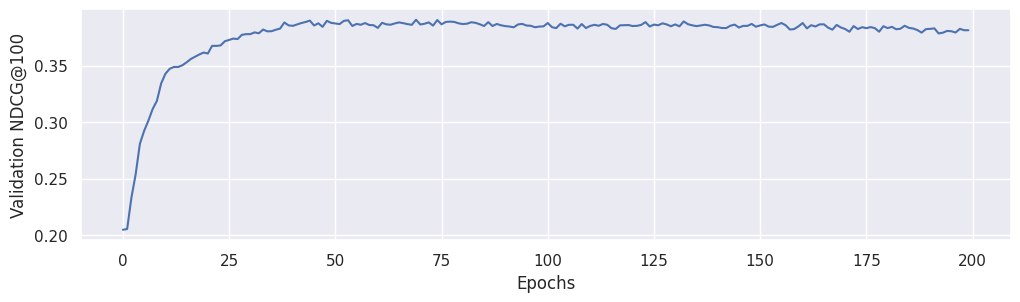

In [51]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

In [52]:
test_data_tr, test_data_te = load_tr_te_data(
    os.path.join(pro_dir, 'test_tr.csv'),
    os.path.join(pro_dir, 'test_te.csv'))

In [53]:
N_test = test_data_tr.shape[0]
idxlist_test = list(range(N_test))

batch_size_test = 30

In [54]:
tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.0)
saver, logits_var, _, _, _ = vae.build_graph()

INFO:tensorflow:Scale of 0 disables regularizer.


In [55]:
chkpt_dir = 'ml-1m/volmount/chkpt/ml-20m/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ml-1m/volmount/chkpt/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-200-70-200-I


In [56]:
all_genres = set(genre for genres_list in item_to_genre.values() for genre in genres_list)
genre_distribution_recommendations = {genre: 0 for genre in all_genres}
genre_distribution_original = {genre: 0 for genre in all_genres}

user_recommendations = {}
n100_list, r20_list, r50_list = [], [], []
top_k = 10 
kl_scores_test = []
with tf.Session() as sess:
    saver.restore(sess, '{}/model'.format(chkpt_dir))

    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        output = sess.run([logits_var, vae.kl_divergence], feed_dict={vae.input_ph: X})
        pred_val = output[0]
        kl_score = output[1]
        pred_val[X.nonzero()] = -np.inf

        for i, pred in enumerate(pred_val):
            top_k_items = np.argsort(pred)[-top_k:][::-1]  # Getting indexes of top-k items
            user_idx = idxlist_test[st_idx + i]  # Getting user index or id
            user_recommendations[user_idx] = top_k_items.tolist()  # Saving recommendations

            for movie_id in top_k_items:
                for genre in item_to_genre.get(movie_id, []):
                    genre_distribution_recommendations[genre] += 1

        true_prefs = test_data_te[idxlist_test[st_idx:end_idx]].nonzero()[1]
        for movie_id in true_prefs:
            for genre in item_to_genre.get(movie_id, []):
                genre_distribution_original[genre] += 1
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))
        kl_scores_test.append(kl_score)

n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)
# avg_kl_score_test = np.mean(kl_scores_test)
# print("Average KL Divergence in Test: {:.4f}".format(avg_kl_score_test))


# Normalizing the KL scores
max_kl_score = max(kl_scores_test)
kl_scores_normalized = [kl / max_kl_score for kl in kl_scores_test]
avg_kl_score_normalized = np.mean(kl_scores_normalized)

print("Average Normalized KL Divergence in Test: {:.4f}".format(avg_kl_score_normalized))


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ml-1m/volmount/chkpt/ml-20m/VAE_anneal200.0K_cap2.0E-01/I-200-70-200-I/model
Average Normalized KL Divergence in Test: 0.9017


/home/vkattera/py-env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/vkattera/py-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [57]:
# Function to replace 0 and NaN values
def replace_values(arr):
    arr[arr == 0] = 1e-6  # Replace 0 with 1e-6
    arr[np.isnan(arr)] = 1e-6  # Replace NaN with 1e-6

replace_values(n100_list)
replace_values(r20_list)
replace_values(r50_list)

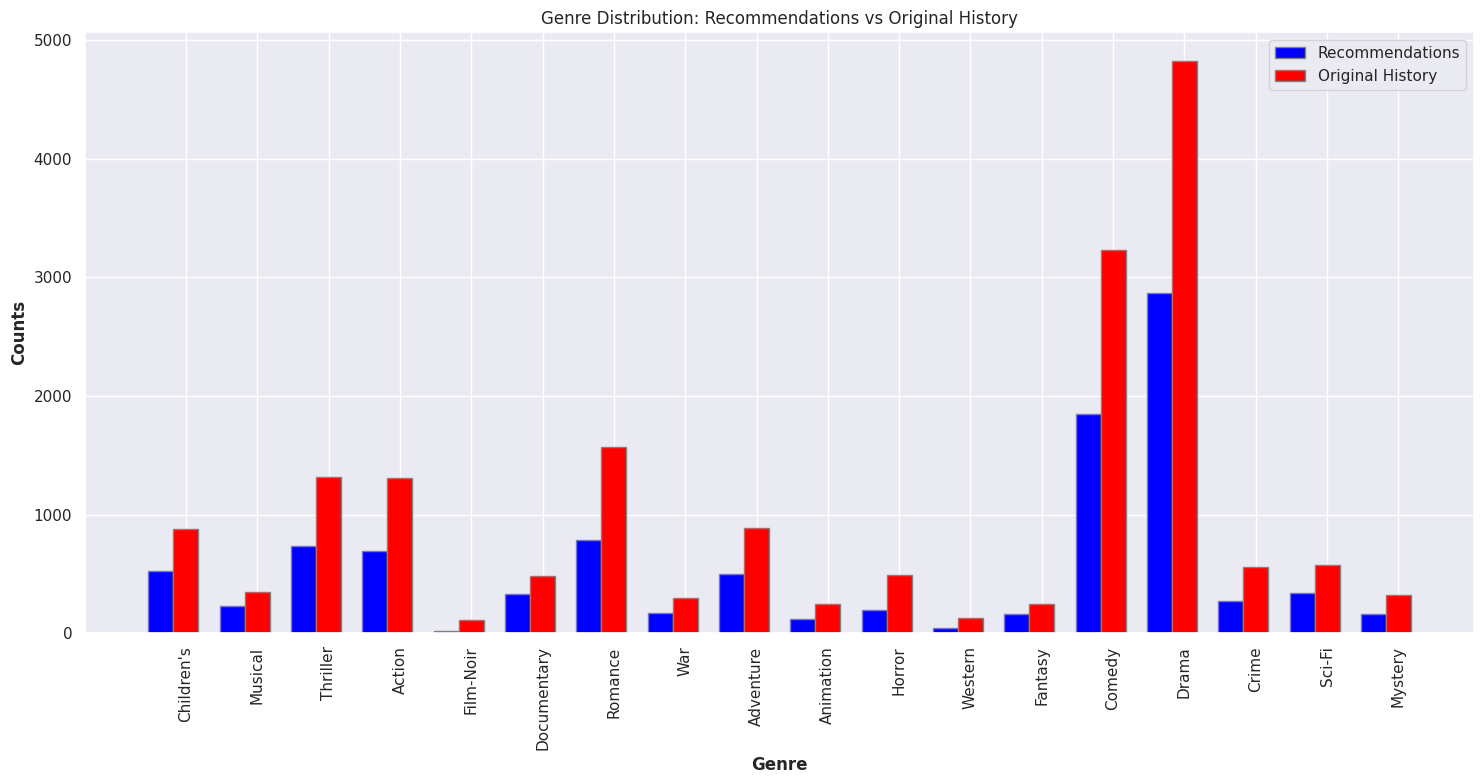

In [58]:
import matplotlib.pyplot as plt

genres = list(all_genres)

recommendation_counts = [genre_distribution_recommendations[genre] for genre in genres]
original_counts = [genre_distribution_original[genre] for genre in genres]

bar_width = 0.35

r1 = np.arange(len(recommendation_counts))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(15, 8))  # You can adjust the size of the figure here
plt.bar(r1, recommendation_counts, color='blue', width=bar_width, edgecolor='grey', label='Recommendations')
plt.bar(r2, original_counts, color='red', width=bar_width, edgecolor='grey', label='Original History')

plt.xlabel('Genre', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(recommendation_counts))], genres, rotation=90)
plt.ylabel('Counts', fontweight='bold')
plt.title('Genre Distribution: Recommendations vs Original History')

plt.legend()
plt.tight_layout()
plt.show()


In [59]:
print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=0.39298 (0.00646)
Test Recall@20=0.32646 (0.00840)
Test Recall@50=0.45656 (0.00886)


In [60]:
p_dims = [200, n_items]

In [61]:
tf.reset_default_graph()
dae = MultiDAE(p_dims, lam=0.01 / batch_size, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = dae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

In [62]:
arch_str = "I-%s-I" % ('-'.join([str(d) for d in dae.dims[1:-1]]))

In [63]:
log_dir = 'ml-1m/volmount/log/ml-20m/DAE/{}'.format(arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

log directory: ml-1m/volmount/log/ml-20m/DAE/I-200-I


In [64]:
chkpt_dir = 'ml-1m/volmount/chkpt/ml-20m/DAE/{}'.format(arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ml-1m/volmount/chkpt/ml-20m/DAE/I-200-I


In [65]:
n_epochs = 200

In [66]:
ndcgs_vad = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf
    
    for epoch in range(n_epochs):
        np.random.shuffle(idxlist)
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            feed_dict = {dae.input_ph: X, 
                         dae.keep_prob_ph: 0.5}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, global_step=epoch * batches_per_epoch + bnum) 
                    
        # compute validation NDCG
        ndcg_dist = []
        for bnum, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
            end_idx = min(st_idx + batch_size_vad, N_vad)
            X = vad_data_tr[idxlist_vad[st_idx:end_idx]]

            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')
        
            pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X} )
            # exclude examples from training and validation (if any)
            pred_val[X.nonzero()] = -np.inf
            ndcg_dist.append(NDCG_binary_at_k_batch(pred_val, vad_data_te[idxlist_vad[st_idx:end_idx]]))
        
        ndcg_dist = np.concatenate(ndcg_dist)
        ndcg_ = ndcg_dist.mean()
        ndcgs_vad.append(ndcg_)
        merged_valid_val = sess.run(merged_valid, feed_dict={ndcg_var: ndcg_, ndcg_dist_var: ndcg_dist})
        summary_writer.add_summary(merged_valid_val, epoch)

        # update the best model (if necessary)
        if ndcg_ > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg_

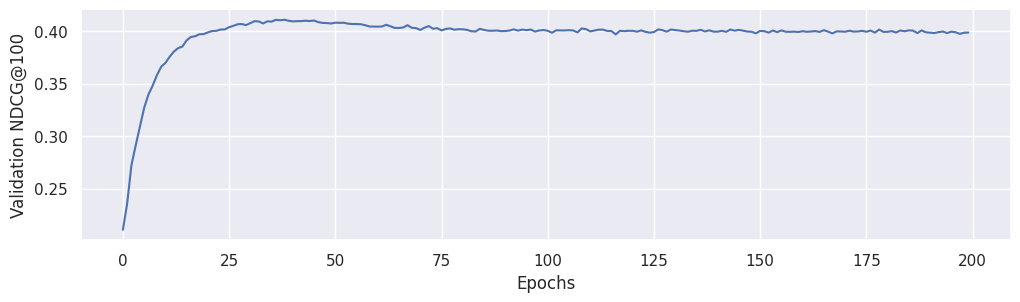

In [67]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_vad)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

In [68]:
tf.reset_default_graph()
dae = MultiDAE(p_dims, lam=0.01 / batch_size)
saver, logits_var, _, _, _ = dae.build_graph()   

In [69]:
chkpt_dir = 'ml-1m/volmount/chkpt/ml-20m/DAE/{}'.format(arch_str)
print("chkpt directory: %s" % chkpt_dir)

chkpt directory: ml-1m/volmount/chkpt/ml-20m/DAE/I-200-I


In [70]:
n100_list, r20_list, r50_list = [], [], []

with tf.Session() as sess:    
    saver.restore(sess, '{}/model'.format(chkpt_dir))
    
    for bnum, st_idx in enumerate(range(0, N_test, batch_size_test)):
        end_idx = min(st_idx + batch_size_test, N_test)
        X = test_data_tr[idxlist_test[st_idx:end_idx]]

        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={dae.input_ph: X})
        pred_val[X.nonzero()] = -np.inf
        n100_list.append(NDCG_binary_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=100))
        r20_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=20))
        r50_list.append(Recall_at_k_batch(pred_val, test_data_te[idxlist_test[st_idx:end_idx]], k=50))

n100_list = np.concatenate(n100_list)
r20_list = np.concatenate(r20_list)
r50_list = np.concatenate(r50_list)

INFO:tensorflow:Restoring parameters from ml-1m/volmount/chkpt/ml-20m/DAE/I-200-I/model


/home/vkattera/py-env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/vkattera/py-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [71]:
replace_values(n100_list)
replace_values(r20_list)
replace_values(r50_list)

In [72]:
print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@20=%.5f (%.5f)" % (np.mean(r20_list), np.std(r20_list) / np.sqrt(len(r20_list))))
print("Test Recall@50=%.5f (%.5f)" % (np.mean(r50_list), np.std(r50_list) / np.sqrt(len(r50_list))))

Test NDCG@100=0.41956 (0.00708)
Test Recall@20=0.35432 (0.00853)
Test Recall@50=0.47462 (0.00846)
